# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
!pip install nbconvert

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\User\AppData\Local\Temp\pip-install-ao1ggnlg\tensorflow-gpu_97e4f846ea5e4f1182c4721f9b3ba42c\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not build

In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        23.1.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.2.0
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7.post1
decorator                    5.1.1
defusedxml                   0.7.1
executing                    1.2.0
Faker                        19.3.0
fastjsonschema               2.18.0
flatbuffers                  23.5.26
fonttools                    4.42.1
gast                         0.4.0
google-auth                  2.22.0
google-auth-oauthlib         1.0.0
google-pasta                

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

C:\Users\User\AppData\Local\Temp\ipykernel_14956\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 374 files belonging to 2 classes.


In [12]:
#Get another batch from the iterator if you rerun it
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

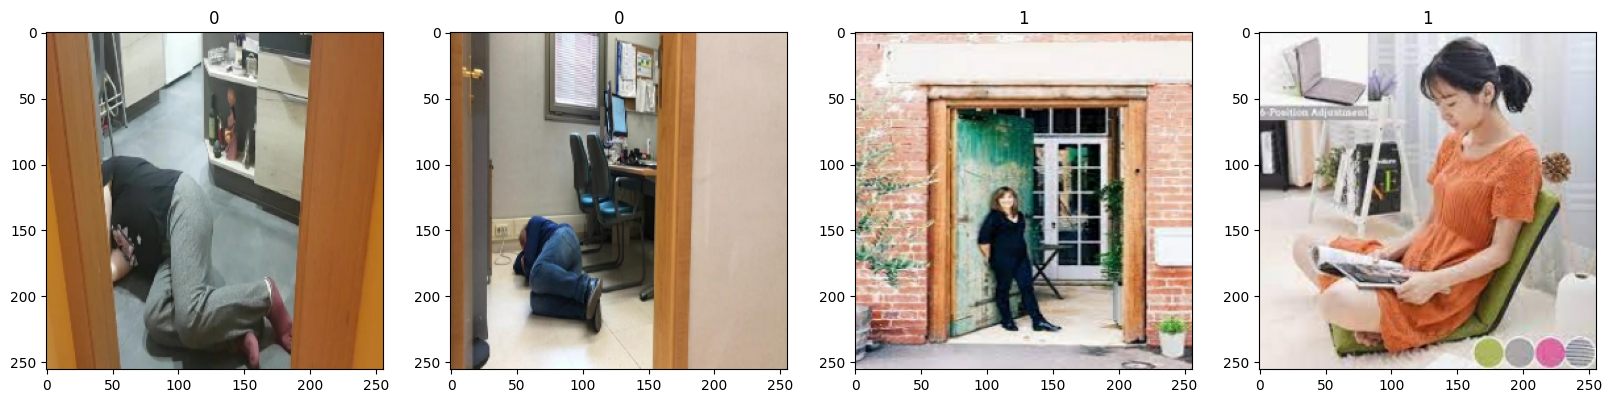

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
#Tensorflow tf dataset map function is used. data.map actually allows you to perform that transformation in pipeline
#x as images and y as labels
#Divide image value to save time in deep learning
#We can't run this for each batch of data pipline, so we have to create another one to scale data
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.959758  , 0.9676011 , 0.96367955],
          [0.959758  , 0.9676011 , 0.96367955],
          [0.959758  , 0.9676011 , 0.96367955],
          ...,
          [0.9882353 , 0.99607843, 0.99215686],
          [0.9843137 , 0.99215686, 0.9882353 ],
          [0.9764706 , 0.98039216, 0.9882353 ]],
 
         [[0.9655484 , 0.97339153, 0.96946996],
          [0.9655484 , 0.97339153, 0.96946996],
          [0.9655484 , 0.97339153, 0.96946996],
          ...,
          [0.9882353 , 0.99607843, 0.99215686],
          [0.9843137 , 0.99215686, 0.9882353 ],
          [0.9882353 , 0.99215686, 1.        ]],
 
         [[0.9764706 , 0.9843137 , 0.98039216],
          [0.97601104, 0.9838542 , 0.9799326 ],
          [0.972549  , 0.98039216, 0.9764706 ],
          ...,
          [0.9882353 , 0.99607843, 0.99215686],
          [0.9876302 , 0.9954733 , 0.99155176],
          [0.9876302 , 0.99155176, 0.9993949 ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

# 5. Split Data

In [17]:
#Split Data into Training and Testing Partition. Validating our data and ensuring that model hasn't overfit
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) #Post Training Deep Learning Model

In [18]:
train_size

8

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


8/8 [==============================] - 6s 630ms/step - loss: 0.9189 - accuracy: 0.4688 - val_loss: 0.6743 - val_accuracy: 0.6094
Epoch 2/20
8/8 [==============================] - 5s 560ms/step - loss: 0.6636 - accuracy: 0.6562 - val_loss: 0.6062 - val_accuracy: 0.7969
Epoch 3/20
8/8 [==============================] - 5s 589ms/step - loss: 0.6679 - accuracy: 0.7305 - val_loss: 0.5817 - val_accuracy: 0.6719
Epoch 4/20
8/8 [==============================] - 6s 685ms/step - loss: 0.5786 - accuracy: 0.7031 - val_loss: 0.4557 - val_accuracy: 0.7656
Epoch 5/20
8/8 [==============================] - 6s 678ms/step - loss: 0.4592 - accuracy: 0.8008 - val_loss: 0.3586 - val_accuracy: 0.8281
Epoch 6/20
8/8 [==============================] - 5s 643ms/step - loss: 0.4029 - accuracy: 0.8242 - val_loss: 0.3827 - val_accuracy: 0.8281
Epoch 7/20
8/8 [==============================] - 5s 632ms/step - loss: 0.3207 - accuracy: 0.8672 - val_loss: 0.3788 - val_accuracy: 0.8125
Epoch 8/20
8/8 [===============

# 8. Plot Performance

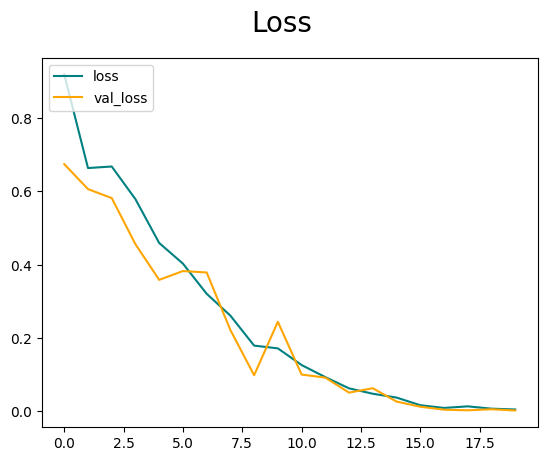

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

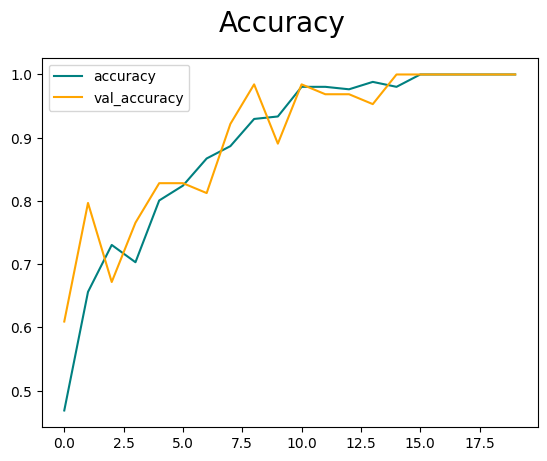

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

1/1 [==============================] - 1s 559ms/step


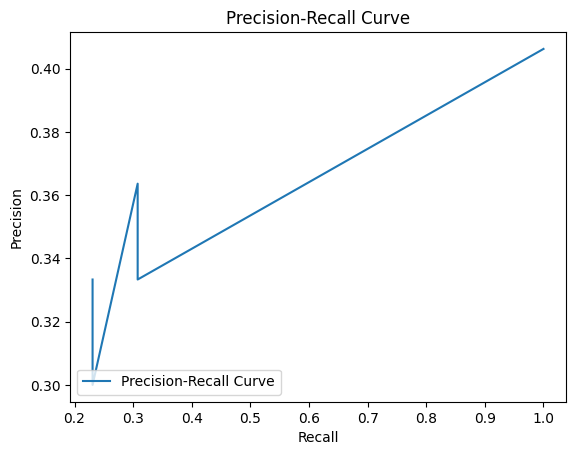

In [32]:
#Precision-Recall Curve:
#To plot the Precision-Recall curve, you'll need the true labels and the predicted probabilities for the positive class.

from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt

y_test = []
for images, labels in test:
    y_test.extend(labels.numpy())
y_test = np.array(y_test)


precisions = []
recalls = []
thresholds = [i/100 for i in range(100)]

yhat_probs = model.predict(test) # get predicted probabilities

for threshold in thresholds:
    yhat = (yhat_probs > threshold).astype(int)
    precision = Precision()
    recall = Recall()
    precision.update_state(y_test, yhat)
    recall.update_state(y_test, yhat)
    precisions.append(precision.result().numpy())
    recalls.append(recall.result().numpy())

plt.plot(recalls, precisions, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()



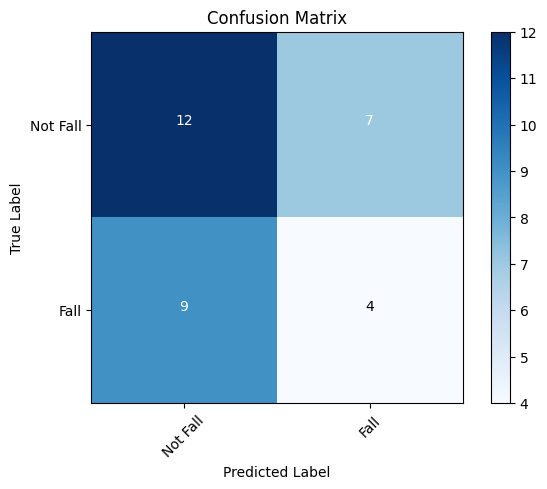

In [35]:
#Confusion Matrix:
#To generate a confusion matrix, you'll need the true labels and the predicted labels.

from tensorflow.math import confusion_matrix
import matplotlib.pyplot as plt
import itertools


yhat_preds = (yhat_probs > 0.5).astype(int)
matrix = confusion_matrix(y_test, yhat_preds).numpy()

# Plot the matrix using matplotlib
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Not Fall', 'Fall'], rotation=45)
plt.yticks(tick_marks, ['Not Fall', 'Fall'])

# Displaying the numbers on the matrix
thresh = matrix.max() / 2.
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    plt.text(j, i, format(matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



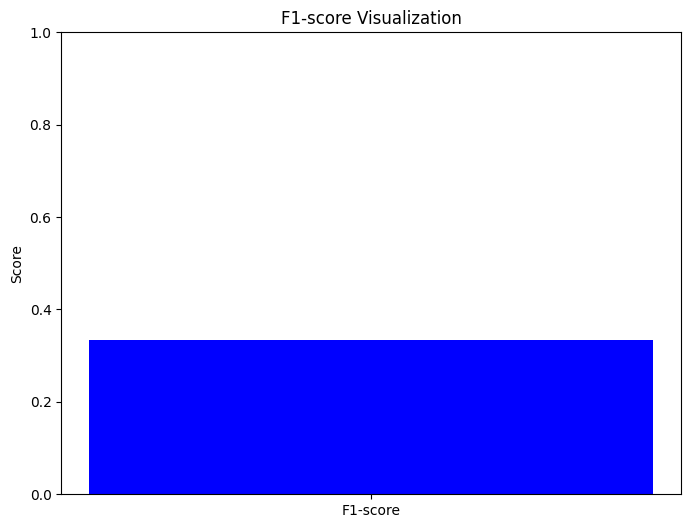

In [37]:
#F1 Score:
#The F1 score is the harmonic mean of precision and recall.

from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt

# Compute Precision and Recall
precision_metric = Precision()
recall_metric = Recall()

precision_metric.update_state(y_test, yhat_preds)
recall_metric.update_state(y_test, yhat_preds)

precision_value = precision_metric.result().numpy()
recall_value = recall_metric.result().numpy()

# Compute F1-score
f1 = 2 * (precision_value * recall_value) / (precision_value + recall_value)

# Plot F1-score
plt.figure(figsize=(8, 6))
plt.bar(['F1-score'], [f1], color=['blue'])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('F1-score Visualization')
plt.show()



# 9. Evaluate

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 233ms/step


In [41]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [42]:
import cv2

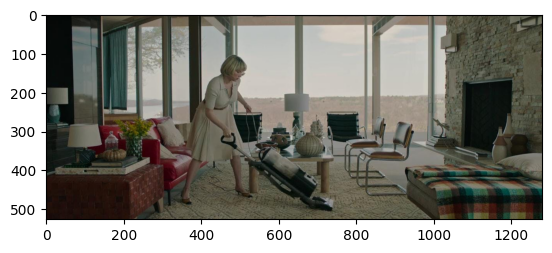

In [43]:
#Testing data outside of the dataset. To test out the image that model has never seen before.

img=cv2.imread('1.jpg') #input random image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #opencv always read image in BGR.
plt.show()

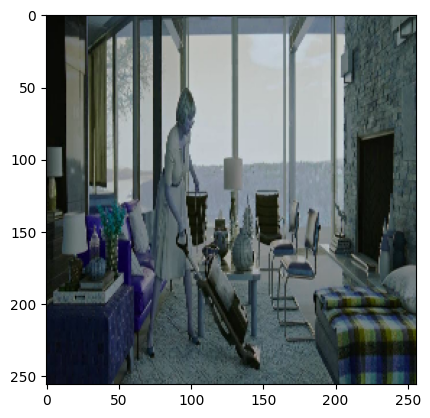

In [44]:
#When we pass data into neural network, the image need to be in shape (256,256) pixels also need to be 3 channel

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [45]:
#The reason why we are doing this prediction is, neural network expects us to pass through a batch of images not a single image, so need to encapsulate
#inside of another set of parentheses or array
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 117ms/step


In [46]:
yhat

array([[0.9997579]], dtype=float32)

In [47]:
if yhat > 0.5: 
    print(f'Predicted class is Fall')
else:
    print(f'Predicted class is Not Fall')

Predicted class is Fall


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifierforFallorNotFall.h5'))

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_model = load_model(os.path.join('models','imageclassifierforFallorNotFall.h5'))

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 74ms/step


array([[0.94322884]], dtype=float32)